# SVGP with efficient parametrisation of the variational distribution

This notebook illustrates how to use the equivalent observation framework to get an efficient parametrisation of an GP classification models.

First, let's load some required packages

In [1]:
import numpy as np
import gpflow
import guepard
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio

from gpflow.utilities import print_summary

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"));

M = 50 # number of inducing points
P = 5  # number of models in ensemble  

/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


We now load the banana dataset: This is a binary classification problem with two classes. 

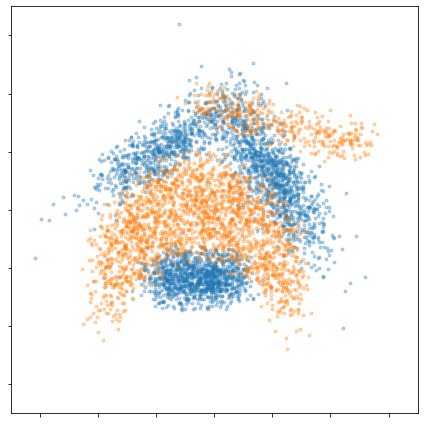

In [2]:
data = sio.loadmat('../../data/banana.mat')
Y = data['banana_Y']
X = data['banana_X']
N = X.shape[0]

x1_lim = [-3.5, 3.5]
x2_lim = [-3.5, 3.5]

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], 'o', color="C0", ms=3, alpha=0.3, label="$y=0$")
ax.plot(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], 'o', color="C1", ms=3, alpha=0.3, label="$y=1$")

ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.tight_layout()

We then split the dataset in four, with one subset per quadrant of the input space:

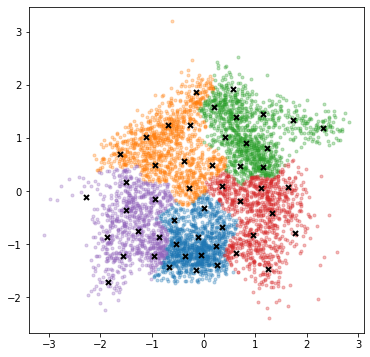

In [3]:
# Compute masks for the four quadrants
Z, label_x = scipy.cluster.vq.kmeans2(X, M, minit='points')

_, label_z = scipy.cluster.vq.kmeans2(Z, P, minit='points') 

masks_x = np.zeros((N, P), dtype="bool")
masks_z = np.zeros((M, P), dtype="bool")
for i in range(P):
    masks_x[:, i] = label_z[label_x] == i
    masks_z[:, i] = label_z == i

fig, ax = plt.subplots(figsize=(6, 6))
for i in range(P):
    ax.plot(X[masks_x[:, i], 0], X[masks_x[:, i], 1], marker="o", linewidth=0, color=f"C{i}", ms=3, alpha=0.3, label="datapoint class")
    ax.plot(Z[label_z == i, 0], Z[label_z == i, 1], marker="x", linewidth=0, color=f"k", ms=5, mew=2,  alpha=1., label="inducing location")
     

We build an SVGP model for each data subset, with 15 inducing variables for each of them. Note that all submodels share the same kernel and that the kernel parameters are fixed.

In [4]:
kernel = gpflow.kernels.Matern32(variance=50., lengthscales=[3., 3.])
gpflow.set_trainable(kernel, False)
lik = gpflow.likelihoods.Bernoulli()
mean_function = gpflow.mean_functions.Zero()

M = []
for mask_x, mask_z in zip(masks_x.T, masks_z.T):
    X_ = X[mask_x, :]
    Y_ = Y[mask_x, :]
    Z_ = Z[mask_z, :]

    m = gpflow.models.SVGP(inducing_variable=Z_, likelihood=lik, kernel=kernel, mean_function=mean_function)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(m.training_loss_closure((X_, Y_)), m.trainable_variables);
    M += [m]
    

/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2022-08-09 15:40:31.997287: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-09 15:40:34.486900: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Let's plot the submodels predictions in the data space.

We can now use the equivalent observation framework to merge these four submodels

In [5]:
m_ens = guepard.EquivalentObsEnsemble(M)
print([p.shape for p in m_ens.trainable_variables])

[TensorShape([11, 2]), TensorShape([11, 1]), TensorShape([1, 66]), TensorShape([9, 2]), TensorShape([9, 1]), TensorShape([1, 45]), TensorShape([11, 2]), TensorShape([11, 1]), TensorShape([1, 66]), TensorShape([9, 2]), TensorShape([9, 1]), TensorShape([1, 45]), TensorShape([10, 2]), TensorShape([10, 1]), TensorShape([1, 55])]


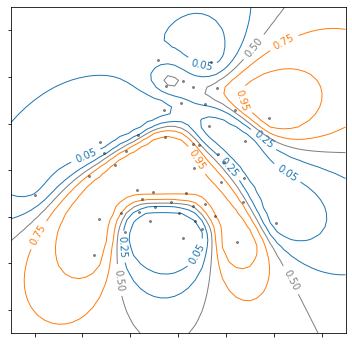

In [6]:
x1_grid = np.linspace(*x1_lim, 50)
x2_grid = np.linspace(*x2_lim, 50)
X1_grid, X2_grid = np.meshgrid(x1_grid, x2_grid) 
Xtest = np.hstack([X1_grid.reshape(-1, 1), X2_grid.reshape(-1, 1)])

Ytest = m_ens.predict_y(Xtest)[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cs = ax.contour(X1_grid, X2_grid, np.reshape(Ytest, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0)
ax.clabel(cs, inline=1, fontsize=10, fmt='%1.2f')

[plt.plot(m.inducing_variable.Z[:, 0], m.inducing_variable.Z[:, 1], "ko", ms=2., alpha=.4) for m in m_ens.models]

ax.set_xticks(np.arange(-3, 4))
ax.set_yticks(np.arange(-3, 4))
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([]);

tf.Tensor(1221.6075774114488, shape=(), dtype=float64)


name,class,transform,prior,trainable,shape,dtype,value
SparseSVGP.ensemble.kernel.variance SparseSVGP.ensemble.models[0].kernel.variance SparseSVGP.ensemble.models[1].kernel.variance SparseSVGP.ensemble.models[2].kernel.variance SparseSVGP.ensemble.models[3].kernel.variance SparseSVGP.ensemble.models[4].kernel.variance SparseSVGP.kernel.variance,Parameter,Softplus,,False,(),float64,50.0
SparseSVGP.ensemble.kernel.lengthscales SparseSVGP.ensemble.models[0].kernel.lengthscales SparseSVGP.ensemble.models[1].kernel.lengthscales SparseSVGP.ensemble.models[2].kernel.lengthscales SparseSVGP.ensemble.models[3].kernel.lengthscales SparseSVGP.ensemble.models[4].kernel.lengthscales SparseSVGP.kernel.lengthscales,Parameter,Softplus,,False,"(2,)",float64,[3. 3.]
SparseSVGP.ensemble.models[0].inducing_variable.Z,Parameter,Identity,,True,"(11, 2)",float64,"[[0.16763, -0.48543..."
SparseSVGP.ensemble.models[0].q_mu,Parameter,Identity,,True,"(11, 1)",float64,[[0.33427...
SparseSVGP.ensemble.models[0].q_sqrt,Parameter,FillTriangular,,True,"(1, 11, 11)",float64,"[[[0.05045, 0., 0...."
SparseSVGP.ensemble.models[1].inducing_variable.Z,Parameter,Identity,,True,"(9, 2)",float64,"[[-0.24719, 1.80457..."
SparseSVGP.ensemble.models[1].q_mu,Parameter,Identity,,True,"(9, 1)",float64,[[-0.01023...
SparseSVGP.ensemble.models[1].q_sqrt,Parameter,FillTriangular,,True,"(1, 9, 9)",float64,"[[[0.02398, 0., 0...."
SparseSVGP.ensemble.models[2].inducing_variable.Z,Parameter,Identity,,True,"(11, 2)",float64,"[[0.6431, 0.95509..."
SparseSVGP.ensemble.models[2].q_mu,Parameter,Identity,,True,"(11, 1)",float64,[[-0.32657...


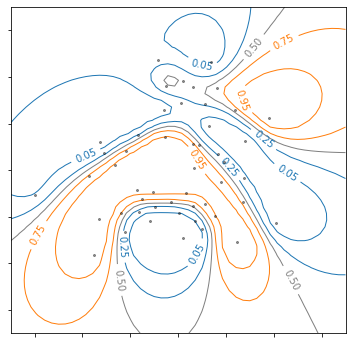

In [7]:
from typing import Any, List, Optional, Tuple, Type
import tensorflow as tf

class SparseSVGP(gpflow.models.svgp.SVGP_deprecated):
    def __init__(self, ensemble: guepard.EquivalentObsEnsemble):

        self.ensemble = ensemble

        Z = tf.concat(values=[m.inducing_variable.Z for m in ensemble.models], axis=0)
        iv = gpflow.inducing_variables.InducingPoints(Z)

        gpflow.models.svgp.SVGP_deprecated.__init__(
            self,
            ensemble.models[0].kernel,
            ensemble.models[0].likelihood,
            inducing_variable=iv,
            mean_function=ensemble.models[0].mean_function,
            whiten=False,
        )

    @property
    def trainable_variables(self):  # type: ignore
        r = []
        for model in self.ensemble.models:
            r += model.trainable_variables
        return r

    @property
    def q_mu(self) -> tf.Tensor:  # type: ignore[override]
        q_mu, _ = self.ensemble.predict_f(self.inducing_variable.Z)
        return q_mu

    @property
    def q_sqrt(self) -> tf.Tensor:  # type: ignore[override]
        _, q_var = self.ensemble.predict_f(self.inducing_variable.Z, full_cov=True)
        q_sqrt = tf.linalg.cholesky(
            q_var + 1e-6 * tf.eye(self.inducing_variable.Z.shape[0], dtype=q_var.dtype)[None]
        )
        return q_sqrt

    @q_mu.setter  # type: ignore[attr-defined, no-redef]
    def q_mu(self, _: Any) -> None:
        """
        q_mu can not be set as it is derived from the submodels.
        We don' throw an error because the super class SVGP
        tries to set a value for q_mu at initialisation.
        """

    @q_sqrt.setter  # type: ignore[attr-defined, no-redef]
    def q_sqrt(self, _: Any) -> None:
        """
        q_sqrt can not be set as it is derived from the submodels.
        We don' throw an error because the super class SVGP
        tries to set a value for q_sqrt at initialisation.
        """
        
m_ssvgp = SparseSVGP(m_ens)

Ytest = m_ssvgp.predict_y(Xtest)[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cs = ax.contour(X1_grid, X2_grid, np.reshape(Ytest, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0)
ax.clabel(cs, inline=1, fontsize=10, fmt='%1.2f')

[plt.plot(m.inducing_variable.Z[:, 0], m.inducing_variable.Z[:, 1], "ko", ms=2., alpha=.4) for m in m_ens.models]

ax.set_xticks(np.arange(-3, 4))
ax.set_yticks(np.arange(-3, 4))
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([]);

print(m_ssvgp.training_loss((X, Y)))

m_ssvgp

In [8]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m_ssvgp.training_loss_closure((X, Y)), m_ssvgp.trainable_variables);

m_ssvgp

name,class,transform,prior,trainable,shape,dtype,value
SparseSVGP.ensemble.kernel.variance SparseSVGP.ensemble.models[0].kernel.variance SparseSVGP.ensemble.models[1].kernel.variance SparseSVGP.ensemble.models[2].kernel.variance SparseSVGP.ensemble.models[3].kernel.variance SparseSVGP.ensemble.models[4].kernel.variance SparseSVGP.kernel.variance,Parameter,Softplus,,False,(),float64,50.0
SparseSVGP.ensemble.kernel.lengthscales SparseSVGP.ensemble.models[0].kernel.lengthscales SparseSVGP.ensemble.models[1].kernel.lengthscales SparseSVGP.ensemble.models[2].kernel.lengthscales SparseSVGP.ensemble.models[3].kernel.lengthscales SparseSVGP.ensemble.models[4].kernel.lengthscales SparseSVGP.kernel.lengthscales,Parameter,Softplus,,False,"(2,)",float64,[3. 3.]
SparseSVGP.ensemble.models[0].inducing_variable.Z,Parameter,Identity,,True,"(11, 2)",float64,"[[0.22087, -0.35845..."
SparseSVGP.ensemble.models[0].q_mu,Parameter,Identity,,True,"(11, 1)",float64,[[0.46043...
SparseSVGP.ensemble.models[0].q_sqrt,Parameter,FillTriangular,,True,"(1, 11, 11)",float64,"[[[0.04559, 0., 0...."
SparseSVGP.ensemble.models[1].inducing_variable.Z,Parameter,Identity,,True,"(9, 2)",float64,"[[-0.28413, 1.85431..."
SparseSVGP.ensemble.models[1].q_mu,Parameter,Identity,,True,"(9, 1)",float64,[[-0.01183...
SparseSVGP.ensemble.models[1].q_sqrt,Parameter,FillTriangular,,True,"(1, 9, 9)",float64,"[[[0.02152, 0., 0...."
SparseSVGP.ensemble.models[2].inducing_variable.Z,Parameter,Identity,,True,"(11, 2)",float64,"[[6.05710e-01, 8.74620e-01..."
SparseSVGP.ensemble.models[2].q_mu,Parameter,Identity,,True,"(11, 1)",float64,[[-0.31845...


tf.Tensor(1218.5859759447958, shape=(), dtype=float64)


[Text(0, -3, ''),
 Text(0, -2, ''),
 Text(0, -1, ''),
 Text(0, 0, ''),
 Text(0, 1, ''),
 Text(0, 2, ''),
 Text(0, 3, '')]

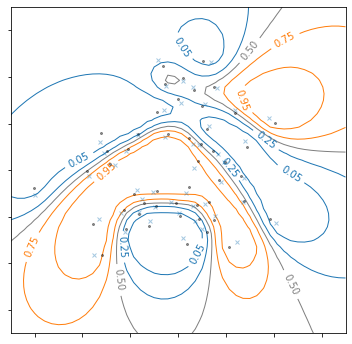

In [13]:
print(m_ssvgp.training_loss((X, Y)))

Ytest = m_ssvgp.predict_y(Xtest)[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cs = ax.contour(X1_grid, X2_grid, np.reshape(Ytest, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0)
ax.clabel(cs, inline=1, fontsize=10, fmt='%1.2f')

[plt.plot(m.inducing_variable.Z[:, 0], m.inducing_variable.Z[:, 1], "ko", ms=2., alpha=.4) for m in m_ssvgp.ensemble.models]
plt.plot(m_ssvgp.inducing_variable.Z[:, 0], m_ssvgp.inducing_variable.Z[:, 1], "C0x", ms=4., alpha=.4)

ax.set_xticks(np.arange(-3, 4))
ax.set_yticks(np.arange(-3, 4))
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

In [10]:
Z = tf.concat(values=[m.inducing_variable.Z for m in m_ens.models], axis=0)
iv = gpflow.inducing_variables.InducingPoints(Z)

q_mu, q_sigma = m_ssvgp.predict_f(Z, full_cov=True)
q_sqrt = tf.linalg.cholesky(q_sigma)

m_fsvgp = gpflow.models.SVGP(
            m_ssvgp.kernel,
            m_ssvgp.likelihood,
            inducing_variable=Z,
            mean_function=m_ssvgp.mean_function,
            q_mu=q_mu,
            q_sqrt=q_sqrt,
            whiten=False,
        )

closure = m_fsvgp.training_loss_closure((X, Y))
print(closure())

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(closure, m_fsvgp.trainable_variables)
print(closure())

Yfsvgp = m_fsvgp.predict_y(Xtest)[0]


tf.Tensor(1224.733529659487, shape=(), dtype=float64)
tf.Tensor(1205.3230139456457, shape=(), dtype=float64)


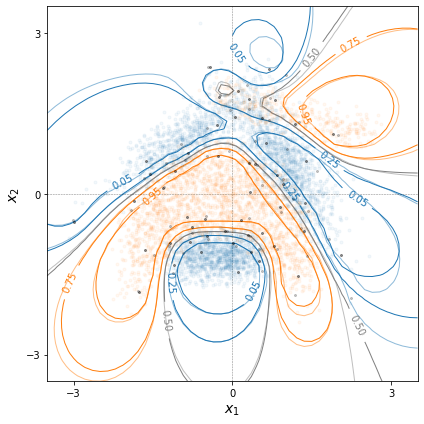

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.axhline(0, color='k', linestyle="dashed", alpha=0.5, linewidth=.5)
ax.axvline(0, color='k', linestyle="dashed", alpha=0.5, linewidth=.5)

ax.plot(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], 'o', color="C0", ms=3, alpha=0.05, label="$y=0$")
ax.plot(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], 'o', color="C1", ms=3, alpha=0.05, label="$y=1$")

cs = ax.contour(X1_grid, X2_grid, np.reshape(Yfsvgp, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0, alpha=.5)

cs = ax.contour(X1_grid, X2_grid, np.reshape(Ytest, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0)

ax.clabel(cs, inline=1, fontsize=10, fmt='%1.2f')

plt.plot(m_ssvgp.inducing_variable.Z[:, 0], m_ssvgp.inducing_variable.Z[:, 1], "ko", ms=2., alpha=.4)
plt.plot(m_fsvgp.inducing_variable.Z[:, 0], m_fsvgp.inducing_variable.Z[:, 1], "ko", ms=2., alpha=.2)
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)
ax.axes.xaxis.set_ticks([-3, 0, 3])
ax.axes.yaxis.set_ticks([-3, 0, 3])

plt.tight_layout()

we can plot the absolute error

max absolute error 0.2038945664828021


(-3.5, 3.5)

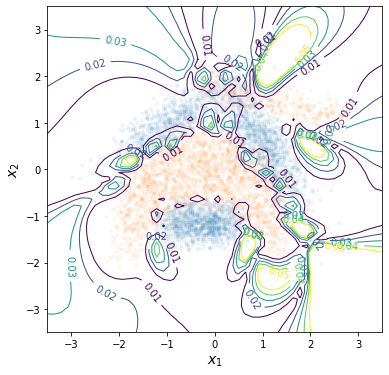

In [12]:
error = (Ytest- Yfsvgp).numpy().flatten()
print("max absolute error", np.max(np.abs(error)))


fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], 'o', color="C0", ms=3, alpha=0.05, label="$y=0$")
ax.plot(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], 'o', color="C1", ms=3, alpha=0.05, label="$y=1$")

cs = ax.contour(X1_grid, X2_grid, np.reshape(np.abs(error), (50, 50)), linewidths=1, levels=[0.01, 0.02, 0.03, 0.04, 0.05])
ax.clabel(cs, inline=1, fontsize=10, fmt='%1.2f')

ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)